**Importing the mnist dataset**

In the first part of this assignment we are going to import the MNIST dataset. MNIST is a famous dataset consisting of many samples of handwritten digits from 0 to 9 with their corresponding label. In this part you don't need to do anything just run the code to import the dataset and visualize a couple of samples.

In [1]:
# import subprocess

# # Installation on Google Colab
# try:
#     import google.colab
#     subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
# except ImportError:
#     pass

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
import random

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/home/luka/anaconda3/envs/NDDL/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
images = mnist.data.astype('float32')
labels = mnist.target.astype('int64')
images /= 255.0

In [5]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

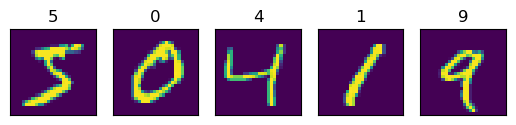

In [6]:
plot_example(images, labels)

In [7]:
images[0].shape

(784,)

**Network**

This part is the code that we completed together. We have the PC-layer class that defines a single predictive coding layer and a network class that can build a predictive coding network by putting together PC-layers. This is a complete and working version of the code from yesterday. You don't need to add anything to it just run this block of code. you can use this code to check your work from yesterday

In [29]:
import numpy as np
class PC_layer:
    def __init__(self,n: int,n_next:int=0,*, inf_rate=0.05, learn_rate=0.005):
        self.n = n
        self.n_next = n_next
        self.restart_activity()
        self.weights=[]
        if n_next is not None and n_next != 0:
            self.weights = self.generate_xavier_random_weights(self.n, self.n_next)
        self.inf_rate = np.float32(inf_rate)
        self.learn_rate = np.float32(learn_rate)
        return

    def generate_xavier_random_weights(self, n_in:int, n_out:int, *, dist='uniform'):
        # using uniform rand:
        if dist == 'uniform':
            return (np.random.rand(n_in, n_out) - 0.5) * np.sqrt(2/(n_in + n_out))
        if dist == 'normal':
            return np.random.randn(n_in, n_out) * np.sqrt(2/(n_in + n_out))
        raise NotImplementedError(f"Unknown distribution: {dist}. Supported distributions are: 'uniform', 'normal'")

    def restart_activity(self):
        self.r = np.zeros([self.n], dtype = np.float32)
        self.e = np.zeros([self.n], dtype = np.float32)

    def inference_step_calc_error(self, r_next):
        '''calculates the error from next layer's prediction
        '''
        is_last_layer = self.n_next == 0
        if is_last_layer:
            return
        # prediction is calculated based on the activity of next layer
        pred = self.weights.dot(r_next)
        # error is the difference between the prediction and current activity
        self.e  = self.r - pred

    def inference_step_calc_r(self, BU_error):
        is_first_layer = len(BU_error) == 0
        if is_first_layer:
            return
        # the activity is adjusted using the value of bottom-up error and activity of error neurons -
        # dont forget the inference rate
        dr = self.inf_rate * (BU_error[0] - self.e)
        self.r += dr


    def learning_step(self,  r_next):
        dW = np.outer(self.e, r_next)
        return dW

    def update_weights(self, dW):
        self.weights += self.learn_rate * dW

    def calculate_MSE(self):
        MSE = sum(self.e**2)/ self.n
        return MSE



class Network():
    def __init__(self, architecture: list[int], *, n_iter_inference:int=40, inf_rate = 0.05, learn_rate = 0.005, **kwargs):
        self.n_layers = len(architecture)
        self.architecture = architecture
        self.n_iter_inference = n_iter_inference
        self.layers: list[PC_layer] = []
        for i in range(self.n_layers-1):
            self.layers.append(PC_layer(self.architecture[i],self.architecture[i+1]))
        self.layers.append(PC_layer(self.architecture[-1]))
        self.inf_rate = inf_rate
        self.learn_rate = learn_rate
        self.standardise_layer_params()

    def standardise_layer_params(self):
        for l in self.layers:
            l.inf_rate = self.inf_rate
            l.learn_rate = self.learn_rate


    def reset_rates(self):
        for layer in self.layers:
            layer.restart_activity()

    def inference_step(self, r_M = None, BU_error = []):
        #perform the inference step for every layer
        for (l, layer) in enumerate(self.layers):
            if l<len(self.layers)-1:
                r_next = self.layers[l+1].r
            else:
                r_next = r_M
            layer.inference_step_calc_error( r_next)
            layer.inference_step_calc_r(BU_error = BU_error)
            if r_next is not None:
                BU_error = [layer.weights.T.dot(layer.e)]
        return

    def infer(self, image, initialize =  True):
        if initialize:
            self.reset_rates()

        I = np.array(image).reshape([-1])
        self.layers[0].r = I
        for i in range(self.n_iter_inference):
            self.inference_step()
        return

    def learning(self, r_M = None):
        for l, layer in enumerate(self.layers):
            if l<len(self.layers)-1:
                r_next = self.layers[l+1].r
            elif r_M is not None:
                r_next = r_M
            else:
                return
            dw=layer.learning_step(r_next = r_next)
            layer.update_weights(dw)
        return

    def train(self, dataset , *, type='serial', epochs = 100, items_per_batch=100):
        if type == 'serial':
            self.train_serial(dataset, epochs)
        elif type == 'batch':
            self.train_batch(dataset, epochs, items_per_batch)

    def train_serial(self, dataset , epochs = 100):
        for epoch in range(epochs):
            for image in dataset:
                self.infer(image)
                self.learning()

    
    def train_batch(self, dataset, epochs=100, items_per_batch=100):
        num_images = len(dataset)

        for epoch in range(epochs):
            for batch_start in range(0, num_images, items_per_batch):
                batch_end = min(batch_start + items_per_batch, num_images)
                batch_images = dataset[batch_start:batch_end]

                # Perform inference on all images in batch
                for image in batch_images:
                    self.infer(image)

                # Perform learning on the entire batch
                self.learning()




**Building and training a network**

Finally, it's time to get to work and train your first Predictive coding network. Please read the code carefully and make sure you understand how to work with this network.

In [30]:
M1 = Network([784,625,400])
#this commands creates a network with 3 layers. This network is called M1. first layer of M1 is the input layer and has 784 neurons(do you know why?), seond and
#third layer have 625 and neurons respectively. You can actually change these two numbers and see what happens

#let's try to train this network on the MNIST dataset (you can use as many input data and as many epochs as you like)
dataset = images[0:30]  # we only \ use part of the dataset to train our network
M1.train(dataset, type='batch', items_per_batch=10, epochs=10)
# M1.train(dataset, type='serial', epochs=10)


Note that we only train the network once and after that we use it to infer images (so no more learning is involved)

**Reconstructing the input**
As we discussed in the class, all the network is trying to do is to build a representation of the sensory input that it is receiving. We can actually check how good these representations are by using them to reconstruct the input. Make sure that you understand how this code works

Try this yourself by showing the network a different novel input and an input it has seen before.

Also, can you try to reconstruct the input from the layer above this one? Hint: you need to multiply the rates of the 3rd layer by the weights of the 2nd layer and then multiply the results by the weights of the first layer. Explain to each other what you think this means and why we do this.

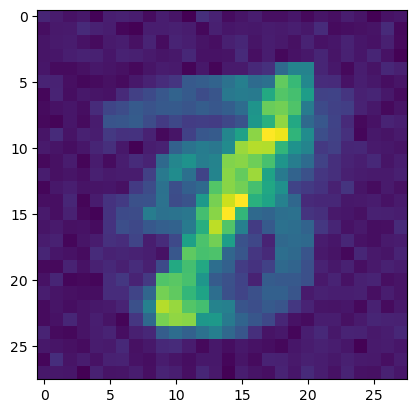

In [29]:
M1.infer(images[40])      #showing the network a novel input and let it run inference
recon = M1.layers[0].weights.dot(M1.layers[1].r)
plt.imshow(recon.reshape(28,28))

In [ ]:
# your code here

**Understanding the network**
Play with the following parameters and try to understand how they affect the training procedure:

*   Inference rate
*   Learning rate
*   Number of inference steps



In [ ]:
#here is how you can change the inference rate
M1.inf_rate = 0.1
M1.standardise_layer_params() #don't forget to call this function everytime you change inf_rate or learn_rate

In [ ]:
# your code here

  How does the Mean Squared Error (MSE) change during the training phase of the network? Calculate MSE for every layer and plot it against training epochs.
  Hint: You can train the network yourself here without using the M1.train command, just use the M1.infer and M1.learning inside a for loop and make sure you calculate the error at each epoch.

In [ ]:
# your code here

**Bonus task: Denoising images**
Let's see how your network holds up against noise.

1. Train your network on the original (not noisy) images.
2. Add Gaussian noise to some images using the function that is provided to you.
3. Feed the network with the noisy images and then reconstruct the input. What do you observe?

In [ ]:
def add_noise(image,mean_n=0, std_n=0.1):
    noise = np.random.normal(mean_n, std_n, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

In [ ]:
# your code here

**Bonus task: Classification**

Are the representations learned by the network for different classes distinct enough to be classified by a linear classifier? let's see.
1. Train your network on the MNIST dataset.
2. Use the trained network to generate latent representations of MNIST images
3. Train a linear classifier on the latent representations and report its performance.


In [ ]:
# your code here

**Bonus: Theoretical questions**
We have discussed the computational and algorithmic accounts of predictive coding. Now its time to take a look at the implementationl account. Read one or two of the papers below and prepare a short summary of what the authors suggest on how predictive coding can potentially be implemented in the brain.



*   [Where is the error? Hierarchical predictive coding through dendritic error computation](https://www.cell.com/action/showPdf?pii=S0166-2236%2822%2900186-2)
*   [Predictive Processing: A Canonical Cortical Computation](https://www.sciencedirect.com/science/article/pii/S0896627318308572)

